In [1]:
import operator
import pandas as pd
import sklearn.preprocessing
import sklearn.utils
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, accuracy_score
import sklearn.metrics as sklm
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, tpe, fmin, Trials
from functools import partial
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pickle
import os

import pickle

# Figure out which RACs are used in the ANN training in orginal database
def return_train_columns(df, cols_selected=False):
    keys = ['RACs']
    removed_columns = []
    if not cols_selected:
        return_columns = ['ligcharge', 'ox', 'spin']
        for col in df.columns:
            for key in keys:
                if key in col and 'init' not in col and 'misc' not in col:
                    if 'Zeff' not in col and '-O-' not in col:
                        return_columns.append(col)
    else:
        print("Using input columns.")
        return_columns = cols_selected
    print("inital: ", len(return_columns))
    df = df.dropna(subset=return_columns)
    thre = 1e-4
    final_cols = []
    for col in return_columns:
        std = np.std(df[col].values)
        if std < thre:
            removed_columns.append(col)
        else:
            final_cols.append(col)
    print("removed: ", removed_columns, len(removed_columns))
    print("feature_used:", final_cols, len(final_cols))
    return final_cols, df

def prepare_data(df, x_scaler, cols_selected=False):
    np.random.seed(0)
    cols_use, df = return_train_columns(df, cols_selected)
    X = np.array(df[cols_use].values)
    X_scaled = x_scaler.transform(X)
    return X_scaled, cols_use

def predict(model_filename, df, x_scaler_filename, y_scaler_filename, cols_selected=False):
    x_scaler = pickle.load(open(x_scaler_filename,'rb'))
    y_scaler = pickle.load(open(y_scaler_filename,'rb'))
    krr = pickle.load(open(model_filename,'rb'))
    X_scaled, cols_use =  prepare_data(df, x_scaler, cols_selected=cols_selected)
    y_pred_scaled = krr.predict(X_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    return y_pred


# Download Data and load data into Pandas

* We will use the Supporting Information Data of Download the data from the following reference, 

Fang Liu, Chenru Duan, and Heather J. Kulik
The Journal of Physical Chemistry Letters 2020 11 (19), 8067-8076
DOI: 10.1021/acs.jpclett.0c02288

* The Supporting Information data is free of charge and opensource, can be directly downloaded by copy&paste the following URL https://pubs.acs.org/doi/suppl/10.1021/acs.jpclett.0c02288/suppl_file/jz0c02288_si_002.zip
* Unzip the zip file, and put the data folder in a location that you know the absolute path
* Fill in the path to your data folder in the 1st line of the next cell.

In [16]:
datapath = '' # Put the path to your data folder here
modelpath = os.path.join(datapath,'models')
filein='../Data/refined_datasets/refined_features.csv' # read in the CSV file containing the features. This file is just for example
df_features = pd.read_csv(filein)

filein2='../Data/refined_datasets/refined_properties.csv' # read in the CSV file containing the properties. This file is just for example
df_props = pd.read_csv(filein2)

## Take a look at the features

In [18]:
df_features

,id,name,set,ligcharge,ox,spin,RACs.D_lc-S-1-ax,RACs.D_lc-S-1-eq,RACs.D_lc-S-2-ax,RACs.D_lc-S-2-eq,...,RACs.mc-T-2-all,RACs.mc-T-3-all,RACs.mc-Z-0-all,RACs.mc-Z-1-all,RACs.mc-Z-2-all,RACs.mc-Z-3-all,RACs.mc-chi-0-all,RACs.mc-chi-1-all,RACs.mc-chi-2-all,RACs.mc-chi-3-all
0,0,metal_fe_ox_3_spin_6_ligstr_pyr_pyr_pyr_pyr_ca...,MD1,0,3,6,0.04,-0.04,0.00,0.72,...,156,192,676,1040,1664,1456,3.3489,31.5858,49.9224,69.540
1,1,metal_co_ox_2_spin_2_ligstr_misc_misc_misc_mis...,MD1,0,2,2,0.00,0.02,0.36,0.00,...,90,144,729,999,1296,1026,3.5344,29.6852,38.9160,37.036
2,2,metal_co_ox_3_spin_5_ligstr_water_water_water_...,MD1,0,3,5,0.72,0.72,0.00,0.00,...,72,0,729,1296,324,0,3.5344,38.8032,49.6320,0.000
3,3,metal_fe_ox_2_spin_1_ligstr_pyr_pyr_pyr_pyr_py...,MD1,0,2,1,-0.04,-0.04,0.72,0.72,...,216,288,676,1092,1872,2184,3.3489,33.3792,55.9980,104.310
4,4,metal_mn_ox_2_spin_2_ligstr_pyr_pyr_pyr_pyr_py...,MD1,0,2,2,-0.04,-0.04,0.72,0.72,...,216,288,625,1050,1800,2100,2.4025,28.2720,47.4300,88.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4860,4860,metal_mn_ox_2_spin_2_ligstr_[SH]-[NH]-[NH]-[SH...,MD2,0,2,2,0.92,0.92,0.92,0.92,...,144,36,625,2400,1200,150,2.4025,23.9940,48.7320,20.460
4861,4861,metal_mn_ox_2_spin_6_ligstr_[SH]-[CH]=[CH]-[SH...,MD2,0,2,6,0.90,0.90,0.90,0.90,...,144,36,625,2400,1050,150,2.4025,23.9940,44.1750,20.460
4862,4862,metal_mn_ox_2_spin_2_ligstr_[SH]-[CH]=[CH]-[SH...,MD2,0,2,2,0.90,0.90,0.90,0.90,...,144,36,625,2400,1050,150,2.4025,23.9940,44.1750,20.460
4863,4863,metal_cr_ox_2_spin_5_ligstr_[SH]-[S]-[S]-[SH]_...,MD2,0,2,5,0.65,0.65,0.00,0.00,...,108,0,576,2304,2448,0,2.7556,25.6968,47.6088,0.000


## Take a look at the properties

In [21]:
df_props

,Unnamed: 0,ID,name,charge,ox,spin,natoms,liglist,ne_valence,energy (ha),...,I_ND,I_D,rND,I_ND_vn,FOD,FOD_vn,energeticHOMO (eV),energeticGap (eV),subset,set
0,0,0,metal_fe_ox_3_spin_6_ligstr_pyr_pyr_pyr_pyr_ca...,3,3,6,49,"[25, 25, 25, 25, 7, 7]",153,-1342.329042,...,0.777794,1.334297,0.368258,0.005084,1.823334,0.011917,-16.558125,1.480299,SRX,MD1
1,1,1,metal_co_ox_2_spin_2_ligstr_misc_misc_misc_mis...,2,2,2,38,"[18, 18, 18, 18, 25, 7]",119,-1037.237964,...,0.220155,0.973060,0.184505,0.001850,0.450361,0.003785,-12.876425,4.639540,SRX,MD1
2,2,2,metal_co_ox_3_spin_5_ligstr_water_water_water_...,3,3,5,19,"[28, 28, 28, 28, 28, 28]",62,-602.463874,...,0.375511,0.409059,0.478620,0.006057,0.871505,0.014057,-22.667080,2.606850,SRX,MD1
3,3,3,metal_fe_ox_2_spin_1_ligstr_pyr_pyr_pyr_pyr_py...,2,2,1,67,"[25, 25, 25, 25, 25, 25]",194,-1612.832027,...,0.487771,1.715463,0.221388,0.002514,0.996572,0.005137,-11.839671,5.175604,SRX,MD1
4,4,4,metal_mn_ox_2_spin_2_ligstr_pyr_pyr_pyr_pyr_py...,2,2,2,67,"[25, 25, 25, 25, 25, 25]",193,-1593.307398,...,0.557232,1.701161,0.246738,0.002887,1.161882,0.006020,-10.938975,3.891227,SRX,MD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4860,4860,4860,metal_mn_ox_2_spin_2_ligstr_[SH]-[NH]-[NH]-[SH...,2,2,2,25,"[107, 107, 107, 107, 107, 107]",91,-2827.995980,...,0.510022,1.141360,0.308846,0.005605,1.085093,0.011924,-14.147196,3.932044,OHLDB,MD2
4861,4861,4861,metal_mn_ox_2_spin_6_ligstr_[SH]-[CH]=[CH]-[SH...,2,2,6,25,"[105, 105, 105, 105, 105, 105]",85,-2728.349183,...,0.305576,0.986143,0.236565,0.003595,0.633828,0.007457,-13.730862,3.961977,OHLDB,MD2
4862,4862,4862,metal_mn_ox_2_spin_2_ligstr_[SH]-[CH]=[CH]-[SH...,2,2,2,25,"[105, 105, 105, 105, 105, 105]",85,-2728.287405,...,0.402298,1.027564,0.281355,0.004733,0.855351,0.010063,-13.812496,4.005515,OHLDB,MD2
4863,4863,4863,metal_cr_ox_2_spin_5_ligstr_[SH]-[S]-[S]-[SH]_...,2,2,5,19,"[109, 109, 109, 109, 109, 109]",90,-4867.647831,...,0.771626,1.450216,0.347291,0.008574,1.693716,0.018819,-13.902294,2.846310,OHLDB,MD2


## Take a look at all the $r_{ND}$ diagnostic values

In [25]:
df_props['rND'].values

array([0.36825776, 0.18450546, 0.47861996, ..., 0.28135455, 0.34729125,
       0.46193074])

## Take a look at the HOMO-LUMO gap values

In [30]:
df_props['energeticGap (eV)'].values

array([1.48029907, 4.63954029, 2.6068502 , ..., 4.00551514, 2.84631035,
       2.69664776])

## Plot $r_{ND}$ vs HOMO-LUMO gap. Is there any correlation between them?

Text(0.5, 0, 'gap (eV)')

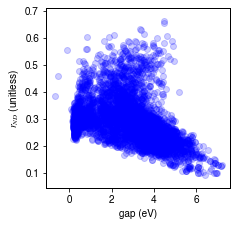

In [41]:
from matplotlib import rc
import matplotlib

fs = 10 # font size
fs_label = 10 # tick label size
fs_lgd = 10 # legend font size
ss = 20 # symbol size
ts = 3 # tick size
slw = 1 # symbol line width
framelw = 1 # line width of frame
lw = 2 # line width of the bar box

fig = plt.figure(figsize=(3.3,3.3))
rc('axes', linewidth=framelw)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.weight":"bold",
    "axes.labelweight":"bold",
    "font.size":fs,
    'pdf.fonttype':'truetype'
})
plt.rcParams['mathtext.fontset']='stix'
# 'stix'

gap = df_props['energeticGap (eV)'].values
rnd = df_props['rND'].values
plt.scatter(gap,rnd,edgecolors=None,c='b',alpha=0.2)
plt.ylabel('$r_{ND}$ (unitless)')
plt.xlabel('gap (eV)')

## Next we are going to try different ways to predict rND

# Predcit $r_{ND}$ from HOMO-LUMO gap with linear regression

In [ ]:
# TODO

# Predict $r_{ND}$ from the RACS features of the molecule with KRR

In [43]:

modelfile = os.path.join(modelpath,'KRR/MD2_rND_krr_model/MD2_rND_krr.pkl')
x_scaler_filename =  os.path.join(modelpath,'KRR/MD2_rND_krr_model/x_scaler.pkl')
y_scaler_filename =  os.path.join(modelpath,'KRR/MD2_rND_krr_model/y_scaler.pkl')
# Note we are not using all features. We are using the selected features verified to be optimal
rfa_features = ["ligcharge","ox","spin","RACs.mc-Z-0-all","RACs.mc-S-0-all","RACs.f-chi-3-all","RACs.D_mc-Z-1-all","RACs.D_mc-S-1-all","RACs.f-Z-1-all","RACs.f-Z-0-all","RACs.f-chi-1-all","RACs.f-chi-0-all","RACs.f-chi-2-all","RACs.f-Z-2-all","RACs.D_mc-chi-2-all","RACs.mc-chi-2-all","RACs.mc-chi-1-all","RACs.f-S-0-all","RACs.f-S-2-all","RACs.D_mc-chi-1-all","RACs.mc-Z-1-all","RACs.f-S-1-all","RACs.f-S-3-all","RACs.f-Z-3-all","RACs.D_mc-S-2-all","RACs.D_mc-Z-2-all","RACs.f-I-2-all","RACs.f-I-0-all","RACs.mc-Z-2-all","RACs.f-chi-0-eq","RACs.f-I-3-all","RACs.f-T-3-all","RACs.lc-S-3-eq","RACs.mc-chi-3-all","RACs.f-T-0-all","RACs.D_mc-chi-3-all","RACs.D_mc-S-3-all","RACs.D_mc-Z-3-all","RACs.f-I-1-all","RACs.lc-chi-2-eq","RACs.D_lc-S-2-ax","RACs.mc-T-2-all","RACs.D_lc-S-2-eq","RACs.D_lc-chi-2-ax","RACs.D_lc-Z-2-ax","RACs.D_lc-Z-2-eq","RACs.D_lc-chi-2-eq","RACs.f-Z-3-eq","RACs.lc-T-3-eq","RACs.mc-I-3-all","RACs.f-Z-3-ax","RACs.D_lc-T-3-ax","RACs.mc-T-3-all","RACs.mc-chi-0-all","RACs.mc-S-1-all","RACs.f-T-2-all","RACs.f-T-1-all","RACs.mc-Z-3-all","RACs.f-T-3-ax","RACs.mc-S-2-all","RACs.f-Z-1-ax","RACs.mc-S-3-all","RACs.D_mc-T-3-all","RACs.f-Z-2-ax","RACs.f-T-3-eq"]
y_predict = predict(modelfile, df, x_scaler_filename, y_scaler_filename,cols_selected=rfa_features)

/Users/fliu31/opt/anaconda3/envs/mols_newplotly/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/fliu31/opt/anaconda3/envs/mols_newplotly/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KernelRidge from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Using input columns.
inital:  65
removed:  [] 0
feature_used: ['ligcharge', 'ox', 'spin', 'RACs.mc-Z-0-all', 'RACs.mc-S-0-all', 'RACs.f-chi-3-all', 'RACs.D_mc-Z-1-all', 'RACs.D_mc-S-1-all', 'RACs.f-Z-1-all', 'RACs.f-Z-0-all', 'RACs.f-chi-1-all', 'RACs.f-chi-0-all', 'RACs.f-chi-2-all', 'RACs.f-Z-2-all', 'RACs.D_mc-chi-2-all', 'RACs.mc-chi-2-all', 'RACs.mc-chi-1-all', 'RACs.f-S-0-all', 'RACs.f-S-2-all', 'RACs.D_mc-chi-1-all', 'RACs.mc-Z-1-all', 'RACs.f-S-1-all', 'RACs.f-S-3-all', 'RACs.f-Z-3-all', 'RACs.D_mc-S-2-all', 'RACs.D_mc-Z-2-all', 'RACs.f-I-2-all', 'RACs.f-I-0-all', 'RACs.mc-Z-2-all', 'RACs.f-chi-0-eq', 'RACs.f-I-3-all', 'RACs.f-T-3-all', 'RACs.lc-S-3-eq', 'RACs.mc-chi-3-all', 'RACs.f-T-0-all', 'RACs.D_mc-chi-3-all', 'RACs.D_mc-S-3-all', 'RACs.D_mc-Z-3-all', 'RACs.f-I-1-all', 'RACs.lc-chi-2-eq', 'RACs.D_lc-S-2-ax', 'RACs.mc-T-2-all', 'RACs.D_lc-S-2-eq', 'RACs.D_lc-chi-2-ax', 'RACs.D_lc-Z-2-ax', 'RACs.D_lc-Z-2-eq', 'RACs.D_lc-chi-2-eq', 'RACs.f-Z-3-eq', 'RACs.lc-T-3-eq', 'RACs.mc-

In [44]:
y = df_props['rND'].values

Text(0.5, 0, '$r_{ND}$ (real)')

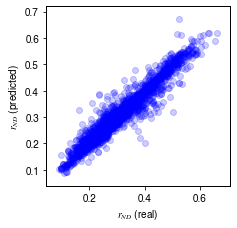

In [45]:
from matplotlib import rc
import matplotlib

fs = 10 # font size
fs_label = 10 # tick label size
fs_lgd = 10 # legend font size
ss = 20 # symbol size
ts = 3 # tick size
slw = 1 # symbol line width
framelw = 1 # line width of frame
lw = 2 # line width of the bar box

fig = plt.figure(figsize=(3.3,3.3))
rc('axes', linewidth=framelw)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.weight":"bold",
    "axes.labelweight":"bold",
    "font.size":fs,
    'pdf.fonttype':'truetype'
})
plt.rcParams['mathtext.fontset']='stix'
# 'stix'

gap = df_props['energeticGap (eV)'].values
rnd = df_props['rND'].values
plt.scatter(y,y_predict,edgecolors=None,c='b',alpha=0.2)
plt.ylabel('$r_{ND}$ (predicted)')
plt.xlabel('$r_{ND}$ (real)')